In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
seed = 42

In [ ]:
%run -i '/content/drive/My Drive/molecular_descriptors_119.ipynb'

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=5e5ea1f87681eab8870a66c2034ebe495b3fb192b0e87b765c33fd02a178b7af
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 40.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.utils import resample
import sklearn
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

### ***balancing and splitting into M traininng sets***




In [ ]:
data = pd.read_csv('/content/drive/My Drive/result_df.csv')

In [ ]:
data.head(2)

,SlogP,SMR,peoe_VSA2,peoe_VSA3,peoe_VSA6,peoe_VSA8,peoe_VSA9,peoe_VSA10,peoe_VSA11,smr_VSA3,...,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42,labels
0,2.69782,93.3108,9.589074,0.000000,48.530937,16.944766,11.250838,5.693928,0.0,4.567100,...,0,1,2,0,0,0,0,0,0,0
1,2.81810,103.2065,4.794537,8.417797,29.800041,23.675598,12.005281,11.791353,0.0,9.622005,...,0,1,2,0,0,0,0,0,0,0


In [ ]:
train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

train_df1 = train_df1.reset_index(drop=True)
valid_df1 = valid_df1.reset_index(drop=True)
test_df1 = test_df1.reset_index(drop=True)

In [ ]:
# Step i: Random Oversampling to balance the classes

# Separate majority and minority classes
majority_class = train_df1[train_df1['labels'] == 0]
minority_class = train_df1[train_df1['labels'] == 1]

# Randomly sample majority class to match the number of minority class samples
minority_oversampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state = seed)

# Combine minority class and downsampled majority class
train_df1 = pd.concat([majority_class, minority_oversampled])

<Axes: >

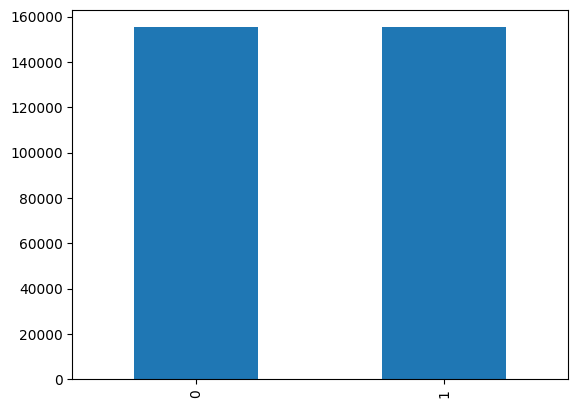

In [ ]:
train_df1['labels'].value_counts().plot.bar()

In [ ]:
bootstrapped_df = resample(train_df1, replace=True, n_samples= 2 * len(train_df1) , random_state = seed)

In [ ]:
print(train_df1.shape[0])
print(bootstrapped_df.shape[0])

310562
621124


In [ ]:
# Step iii: Randomize and split into M different balanced training sets

shuffled_df = bootstrapped_df.sample(frac=1, random_state = seed)  # 'frac=1' shuffles all rows

# Reset the index of the shuffled DataFrame
shuffled_df.reset_index(drop=True, inplace=True)

In [ ]:
#shuffled_df = pd.read_excel('/content/drive/My Drive/shuffled_df.xlsx')

In [ ]:
# Define the number of subsets 'm'
m = 17

# Calculate the number of rows in each subset
subset_size = len(shuffled_df) // m

# Create a list to store the subsets
subsets = []

# Split the DataFrame into 'm' equal-sized subsets
for i in range(m):
    start_idx = i * subset_size
    end_idx = (i + 1) * subset_size if i < m - 1 else None
    subset = shuffled_df.iloc[start_idx:end_idx]
    subsets.append(subset)

In [ ]:
print(len(subsets))
print(subsets[0].shape)

17
(36536, 119)


### ***Feature selection***

In [ ]:
sub = subsets
v_value = 0.001
threshold = 0.05
feat_list = []

for frame in sub:

  frame = varaince_filter(frame , v_value, 'labels')
  frame = permutation_filter(frame, 'labels')
  frame = correlation(frame, threshold, 'labels')
  frame = frame.drop('labels', axis = 1)
  feat_list.append(frame.columns.to_list())
  print(len(feat_list))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [ ]:
from itertools import chain

# Flatten the list of lists and remove duplicates
merged_list = list(set(chain(*feat_list)))

print(merged_list)

['NumAtoms', 'MQN15', 'NumSaturatedRings', 'NumLipinskiHBD', 'MQN7', 'MQN2', 'MQN19', 'MQN33', 'NumHeavyAtoms', 'NumLipinskiHBA', 'MQN34', 'NumHBD', 'MQN25', 'MQN3', 'NumAromaticHeterocycles', 'NumStereocenters', 'NumRotatableBonds', 'NumRings', 'NumAmideBonds', 'MQN24', 'smr_VSA2', 'MQN37', 'NumHBA', 'MQN5', 'MQN38']


In [ ]:
merged_list.append('labels')

In [ ]:
len(merged_list)

26

In [ ]:
merged_list

['NumAtoms',
 'MQN15',
 'NumSaturatedRings',
 'NumLipinskiHBD',
 'MQN7',
 'MQN2',
 'MQN19',
 'MQN33',
 'NumHeavyAtoms',
 'NumLipinskiHBA',
 'MQN34',
 'NumHBD',
 'MQN25',
 'MQN3',
 'NumAromaticHeterocycles',
 'NumStereocenters',
 'NumRotatableBonds',
 'NumRings',
 'NumAmideBonds',
 'MQN24',
 'smr_VSA2',
 'MQN37',
 'NumHBA',
 'MQN5',
 'MQN38',
 'labels']

Apply the results of features' selection on all trainsets and test set.

In [ ]:
filtered_df = []

for frame in subsets:
  frame = frame [merged_list]
  filtered_df.append(frame)

In [ ]:
test_df = test_df1[merged_list]

### ***Creating M base classifiers***

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2 , 3 ,5],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 3, 5],
    'min_impurity_decrease': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5]
    }

# Create a list to store the trained decision trees
decision_trees = []

# Assuming 'subsets' is a list of DataFrames
for subset in filtered_df:

        # Create a Decision Tree classifier
        tree = DecisionTreeClassifier()

        # Split the DataFrame into features (X) and target (y)
        y = subset['labels']
        X = subset.drop('labels', axis = 1)

        grid_search = GridSearchCV(estimator= tree, param_grid=param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X, y)
        best_params = grid_search.best_params_

        # Create a new model with the best hyperparameters
        tree = DecisionTreeClassifier(**best_params)

        tree.fit(X,y)

        # Append the trained decision tree to the list
        decision_trees.append(tree)
        print(len(decision_trees))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [ ]:
from mlxtend.classifier import EnsembleVoteClassifier

eclf2 = EnsembleVoteClassifier(clfs= decision_trees , voting="hard" ,fit_base_estimators = False)
eclf2.fit(None,np.array([0,1]))

/usr/local/lib/python3.10/dist-packages/mlxtend/classifier/ensemble_vote.py:172: UserWarning: fit_base_estimators=False enforces use_clones to be `False`
  warnings.warn(


EnsembleVoteClassifier(clfs=[DecisionTreeClassifier(criterion='log_loss',
                                                    splitter='random'),
                             DecisionTreeClassifier(criterion='log_loss'),
                             DecisionTreeClassifier(criterion='entropy',
                                                    splitter='random'),
                             DecisionTreeClassifier(criterion='log_loss'),
                             DecisionTreeClassifier(criterion='entropy'),
                             DecisionTreeClassifier(),
                             DecisionTreeClassifier(criterion='ent...
                             DecisionTreeClassifier(criterion='log_loss',
                                                    splitter='random'),
                             DecisionTreeClassifier(splitter='random'),
                             DecisionTreeClassifier(criterion='log_loss',
                                                    splitter='random'),
                             DecisionTreeClassifier(criterion='log_loss',
                                                    splitter='random'),
                             DecisionTreeClassifier(criterion='log_loss',
                                                    splitter='random'),
                             DecisionTreeClassifier(criterion='log_loss')],
                       fit_base_estimators=False, use_clones=False)

In [ ]:
y_test = test_df['labels']
X_test = test_df.drop('labels', axis = 1)

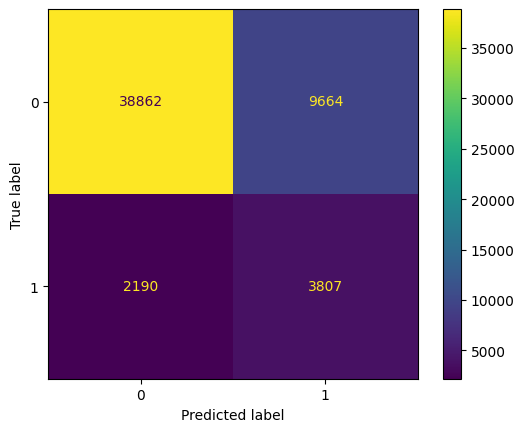

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = eclf2.predict(X_test)

cm = confusion_matrix(y_test , preds)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ccr = (specificity+ sensitivity)/2
ppv = (tp / (tp + fp))
npv = (tn / (tn + fn))

print('sen:{}'.format(sensitivity))
print('spe:{}'.format(specificity))
print('CCR:{}'.format(ccr))
print('ppv:{}'.format(ppv))
print('nen:{}'.format(npv))

sen:0.6348174087043522
spe:0.8008490293863084
CCR:0.7178332190453303
ppv:0.2826070818795932
nen:0.9466530254311605


In [ ]:
from sklearn.metrics import roc_auc_score

probas = eclf2.predict_proba(X_test)
prob1 = probas[: , 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_test, prob1)

print("AUC-ROC Score:", auc_score)

AUC-ROC Score: 0.7914447562293835


In [ ]:
import joblib

# Save the model using joblib
joblib.dump(eclf2, '/content/drive/My Drive/ensemble_model.joblib')


['/content/drive/My Drive/ensemble_model.joblib']

## ***Ten runs***

In [ ]:
random_seed_list = [123, 80, 789, 567, 890, 345, 678, 901, 456, 12]

In [ ]:
ccr_list = []
sen_list = []
spe_list = []
ppv_list = []
npv_list = []
auc_list = []


for i in random_seed_list:
  seed = i
  %run -i '/content/drive/My Drive/big dataset/ise_different_runs/ise_blank.ipynb'
  ccr_list.append(ccr)
  sen_list.append(sensitivity)
  spe_list.append(specificity)
  ppv_list.append(ppv)
  npv_list.append(npv)
  auc_list.append(auc_score)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
sen:0.6368184092046023
spe:0.8014672546676008
CCR:0.7191428319361015
ppv:0.2838772021110533
nen:0.9469685902118334
AUC-ROC Score: 0.7850238762239243
pass
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
sen:0.6448224112056028
spe:0.8021679099863991
CCR:0.7234951605960009
ppv:0.2871463577634217
nen:0.9481196414653157
AUC-ROC Score: 0.7953558326512443
pass
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
sen:0.6326496581624146
spe:0.8095866133619091
CCR:0.7211181357621619
ppv:0.29108485499462944
nen:0.9469015883728217
AUC-ROC Score: 0.7873938549183643
pass
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
sen:0.625479406369851

In [ ]:
auc_list

[0.7850238762239243,
 0.7953558326512443,
 0.7873938549183643,
 0.7825811853569972,
 0.7942012262364954,
 0.788920095789559,
 0.7888453252715464,
 0.7927913282775831,
 0.788019992287424,
 0.7850967877019881]

In [ ]:
# Calculate mean and standard deviation
ccr_mean = np.mean(ccr_list)
ccr_std = np.std(ccr_list)

sen_mean = np.mean(sen_list)
sen_std = np.std(sen_list)

spe_mean = np.mean(spe_list)
spe_std = np.std(spe_list)

ppv_mean = np.mean(ppv_list)
ppv_std = np.std(ppv_list)

npv_mean = np.mean(npv_list)
npv_std = np.std(npv_list)

auc_mean = np.mean(auc_list)
auc_std = np.std(auc_list)

# Print the results
print(f'Mean and Standard Deviation of CCR: {ccr_mean:.2f} ± {ccr_std:.2f}')
print(f'Mean and Standard Deviation of Sensitivity: {sen_mean:.2f} ± {sen_std:.2f}')
print(f'Mean and Standard Deviation of Specificity: {spe_mean:.2f} ± {spe_std:.2f}')
print(f'Mean and Standard Deviation of PPV: {ppv_mean:.2f} ± {ppv_std:.2f}')
print(f'Mean and Standard Deviation of NPV: {npv_mean:.2f} ± {npv_std:.2f}')
print(f'Mean and Standard Deviation of AUC: {auc_mean:.2f} ± {auc_std:.2f}')

Mean and Standard Deviation of CCR: 0.72 ± 0.00
Mean and Standard Deviation of Sensitivity: 0.64 ± 0.01
Mean and Standard Deviation of Specificity: 0.80 ± 0.00
Mean and Standard Deviation of PPV: 0.29 ± 0.00
Mean and Standard Deviation of NPV: 0.95 ± 0.00
Mean and Standard Deviation of AUC: 0.79 ± 0.00
